# Image Segmentation

In this project we will focus on automatically segmenting the tumour in an MRI brain image.\
Here we will segment the tumour using 2 different methods where one will create a mask of the tumour using Otsu thresholding method, and the other one will be segmenting the tumour by growing the tumour region using markers and the watershed method.\
The two automatic methods and their results will be first presented and at the end the tumour area will be calculate.

## Otsu thresholding

The get_mask function is a method that segments the tumour by creating a mask of it. This method calls 2 other functions which are the distance_color_space method and the otsu_threshold one. The steps that are followed to segment the tumour are the following:

#### Step 1:
Since the tumour is perfectly visible in white, we will first start by creating a mask based on $\textbf{the distance color space}$ from the white pixels in the tumour to the rest of the pixels in the image.\
The distance_color_space function returns a distance color map from the white pixels in the tumour to the rest of pixels in the image.

#### Step 2:
To $\textbf{find the optimal threshold}$ that will separate the white tumour from the rest of the image, we will compute the histogram of this color space map and then apply the otsu_threshold method to it. This method takes as an argument the histogram of the color space map and returns the best possible threshold to seperate the tumour region from the rest of the image.\
It is possible to automatically use the threshold_otsu method from skimage filters library but this one takes as an argument the distance map, and we prefer here to use the histogram of the distance map as an argument.

#### Step 3:
A $\textbf{mask}$ will be created based on the threshold value returned by the otsu_threshold method. Since there are some white regions in the image as well that are no tumour, and to avoid selecting them with the tumour we're interested in, we will apply a morphological filter (combination of opening and closing) to remove that noise from the mask (the white pixels in the image that are not a tumour).\
This whole process is given by the get_mask method that takes as an argument the image and the position of the object in the image we are interested in and returns the mask that selects only that object.
 

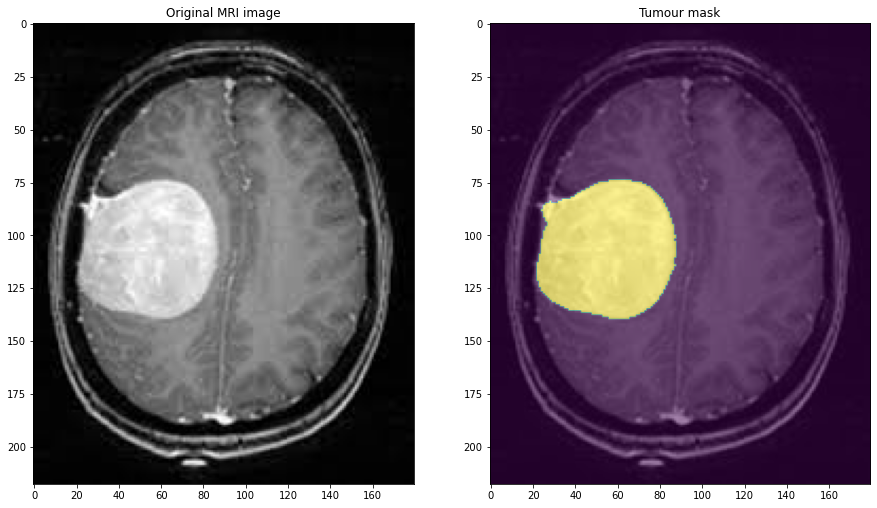

In [208]:
from skimage.io import imread,imshow,imsave
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import opening,closing,disk,watershed
import numpy as np
%matplotlib inline


def distance_color_space(im,coords):
    refcolor = im[coords[0],coords[1]]
    dmap=np.sqrt(((im-refcolor)**2).sum(axis=2))
    
    return dmap

def otsu_threshold(h):
    
    h=h*1./h.sum()  #transforming the histogram into a probability
    
    #Computing for every possible threshold the var_w, var_b and separability
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    
    for t in range (1,len(h)-1):  #looking at every possible threshold but not thresholds 0 and 255
        
        #class probabilities
        w1=h[:t].sum()
        w2=h[t:].sum()
        
        #class means
        m1=(np.arange(0,t)*h[:t]).sum()/w1
        m2=(np.arange(t,len(h))*h[t:]).sum()/w2
        
        #class variances
        s1=(((np.arange(0,t)-m1)**2)*h[:t]).sum()/w1
        s2=(((np.arange(t,len(h))-m2)**2)*h[t:]).sum()/w2
        
        #intra-class and inter-class
        sw=w1*s1+w2*s2
        sb=w1*w2*((m2-m1)**2)
        
        #separability 
        l=sb/sw
        var_within[t]=sw
        var_between[t]=sb
        
    sep[1:-1] = var_between[1:-1]/var_within[1:-1]
    optimal_t = np.argmax(sep)          #gives the index of the element in the array that has the max value 
    
    return optimal_t

def get_mask(im,coords=(100,50)):
    
    dmap=distance_color_space(im.astype('float'),coords)
    
    h,bins=np.histogram(dmap.flatten(),range(257))
    t = otsu_threshold(h)
    
    mask = dmap<t
    mask = closing(opening(mask, disk(3)), disk(2))

    return mask

im=imread('mri_brain.jpg')

tumour=get_mask(im)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Original MRI image')
plt.imshow(im)
plt.subplot(1,2,2)
plt.title('Tumour mask')
plt.imshow(im)
plt.imshow(tumour,alpha=0.5)
plt.show()

## Markers and the Watershed method

Another way of segmenting the tumour is by positioning markers on the MRI image and using the watershed process. In this process, each marker will start a region and grow it. Different markers will be competing to grow their own region. When the borders of a region meet the borders of an other marker's region, the 2 markers will stop growing their regions in that direction. At the end the borders between all regions will be determined. 

The get_tumour method segments the tumour by calling the get_markers function and applying a watershed. The get_markers function automatically returns a number of markers based on the local maxima of the input image, and a gradient that determines the different borders of the image.\
This 2 arguments are used in the get_tumour function by the watershed method. Since the markers will give us different regions, and since each region is labeled by the label method from the skimage library, we can choose to select one region directly by knowing its label. The second argument in the get_tumour function allows us to choose the region that we want to select in the image. If no region is specified in the argument, the function will return by default all the regions of the watershed mask.\
The tumour region has a label of 4 and therefore we will only show the region with this label to segment the tumour.

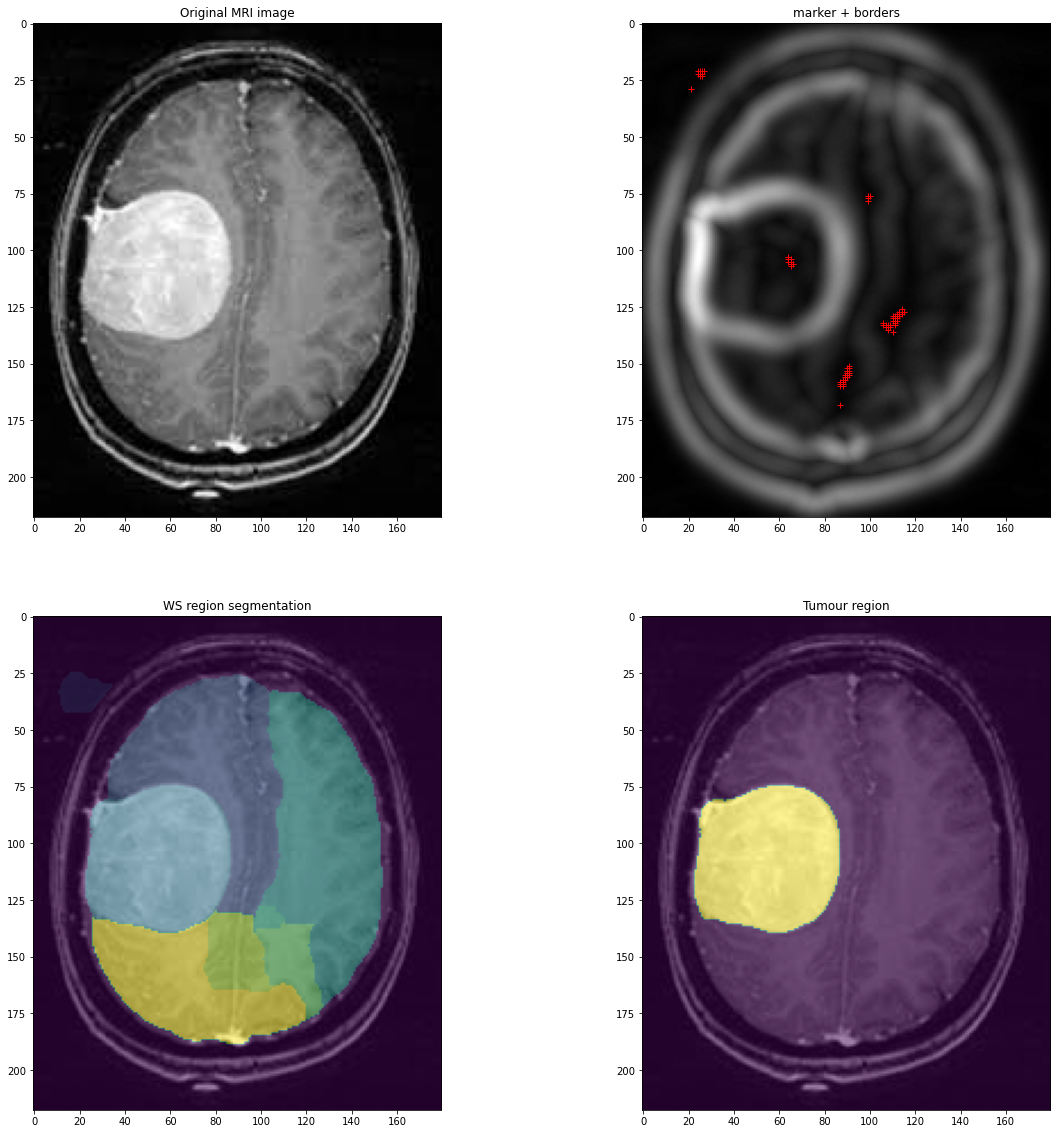

In [203]:
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
from skimage.measure import label
from skimage.util import img_as_ubyte


def get_markers(im, indices=False):
    
    im=rgb2gray(im)
    im_ = gaussian(im, sigma=4)
    grad = rank.gradient(img_as_ubyte(im_),disk(5)).astype('int')
    
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=20,indices=indices),grad

def get_tumour(im,region='d'):
    
    markers,grad=get_markers(im)
    markers = label(markers)
    ws = watershed(grad,markers)
    if (region=='d'): res=ws 
    else:
        res= (ws==region)
    return res

markers,grad = get_markers(im, True)

ws=get_tumour(im)
ws_tumour=get_tumour(im,4)

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title('Original MRI image')
plt.imshow(im)
plt.subplot(2,2,2)
plt.title('marker + borders')
plt.imshow(grad, cmap=plt.cm.gray)
plt.plot(markers[:,1],markers[:,0],'r+')
plt.subplot(2,2,3)
plt.title('WS region segmentation')
plt.imshow(im)
plt.imshow(ws,alpha=0.5)
plt.subplot(2,2,4)
plt.title('Tumour region')
plt.imshow(im)
plt.imshow(ws_tumour,alpha=0.5)
plt.show()

##### The Otsu thresholding method is more convenient for this MRI image since we have only one tumour and therefore only one object of interest present in the image. 
##### The watershed technic is much more convenient for cases where we have different objects of interest with the same specifications (for example several of tumours). At that moment, the watershed technic can be combined to the Otsu thresholding method to find a mask where the position of markers will be set based on the distance from the center of each object of interest in the mask from the background (using the distance_transform_edt method from scipy library) and then using the watershed method and finally labeling each object separately.

## Tumour area

To calculate the tumour area knowing that the image has a resolution of 0.115 cm/px in both axis, we will first have to get the number of pixels of the tumour. For that we have 2 options:
- Browse every pixel of the watershed segmented mask and increment the total of tumour pixels every time we cross a nonzero pixel (the watershed mask has a value of 1 on the position of the tumour, and zero values everywhere else)
- Directly use the count_nonzero method from the numpy library that returns the number of nonzero values in an numpy

The tot_pixel_tumor function uses the first option, whereas the second option is used to calculate the size of the tumour by the size_tumour function.

In [212]:
def tot_pixel_tumour(im,coords=(100,50)):
    
    total=0
    tumour=get_mask(im,coords)
    
    for j in range(tumour.shape[0]):
        for i in range(tumour.shape[1]):
            if (tumour[j,i]==1): total+=1
            
    return total

t=tot_pixel_tumour(im)
print(t)

3495


Once we have the number of pixels in the tumour and since the tumour has no specific shape to use a precise mathematic formula to calculate its area, we will proceed as following:
- calculating the area of the watershed mask image (with its white and black pixels), refered in the function by the variable im_area
- calculating the ratio between the pixels in the tumour and the ones in the whole watershred mask 
- getting the tumour area by multiplying the watershed mask image by the tumour ratio

In [215]:
def size_tumour(im,coords=(100,50)):
    
    tumour=get_mask(im,coords)
    
    total=np.count_nonzero(tumour) #alternative of the tot_pixel_tumour method
    
    im_area = (0.115**2)*im.size
    
    tumour_ratio =(total/im.size)
    
    tumour_area=tumour_ratio*im_area
    
    return float(tumour_area)

tot=tot_pixel_tumour(im)
tumour_area=size_tumour(im)

print("Total number of pixels in the tumour : %d"%tot)
print("Tumour area : %.2f cm^2"%tumour_area)

Total number of pixels in the tumour : 3495
Tumour area : 46.22 cm^2
